In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\Airtel")

In [3]:
##read datasets
df=pd.read_csv(os.getcwd()+r"\Data Files\airtel_export.csv")


In [4]:
df.head()

,SKP_CREDIT_CASE,CATEGORY,SUB_CATEGORY,DECISION_MONTH,PRODUCT_GROUP,CLIENT_EXI_3M,NTC_FLAG,RISK_SCORE,DECISION_OVERALL,RISK_FPD10,...,RISK_FSTPD30,FLAG_1PCT_PHANTOM,RISK_AGRF10,RISK_AGRF30,RISK_AGRF60,RISK_AGRF90,AIRTEL_SCORE,REJECT_TYPE,RISK_SCORE_PENTILE,AIRTEL_SCORE_PENTILE
0,331466359,PROD,PROD,01-01-21,CD,N,Others,0.000450,Approved,0,...,0,0,0,0,0,0,0.057139,SCORE_REJECT,1,1
1,332040142,PROD,PROD,01-01-21,CD,N,Others,0.000483,Approved,0,...,0,0,0,0,0,0,0.042479,SCORE_REJECT,1,1
2,328208585,PROD,PROD,01-12-20,CD,N,Others,0.000492,Approved,0,...,0,0,1,0,0,0,0.150840,SCORE_REJECT,1,4
3,311456042,jun20,JUN20_APPROVED,01-07-20,CD,N,Others,0.000503,Approved,0,...,0,0,1,1,1,1,0.042234,SCORE_REJECT,1,1
4,330906930,PROD,PROD,01-01-21,CD,N,Others,0.000582,Approved,0,...,0,0,0,0,0,0,0.060177,SCORE_REJECT,1,1


In [5]:
df["DECISION_MONTH"] = pd.to_datetime(df["DECISION_MONTH"], format = '%d-%m-%y')

In [6]:
sns.set_style("white")

initial = df[df["DECISION_MONTH"]<pd.datetime(2020,10,1)]["AIRTEL_SCORE"]
new = df[df["DECISION_MONTH"]>=pd.datetime(2020,10,1)]["AIRTEL_SCORE"]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


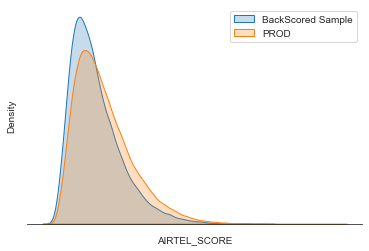

In [7]:
plot = sns.kdeplot(initial, shade=True, label = 'BackScored Sample')
plot = sns.kdeplot(new, shade=True, label = 'PROD')
plot.set(yticklabels=[], xticklabels = [])
plot.legend()
sns.despine(left=True)

In [8]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

buckets = 10
raw_breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
breakpoints = scale_range(raw_breakpoints, np.min(initial), np.max(initial))

In [9]:
initial_counts = np.histogram(initial, breakpoints)[0]
new_counts = np.histogram(new, breakpoints)[0]

In [10]:
df = pd.DataFrame({'Bucket': np.arange(1, 11), 'Breakpoint Value':breakpoints[1:], 'BackScored Count':initial_counts, 'Prod Count':new_counts})
df['BackScored Percent'] = df['BackScored Count'] / len(initial)
df['Prod Percent'] = df['Prod Count'] / len(new)

In [11]:
df['Prod Percent'][df['Prod Percent'] == 0] = 0.001

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
df

,Bucket,Breakpoint Value,BackScored Count,Prod Count,BackScored Percent,Prod Percent
0,1,0.063546,5683,28971,0.178497,0.115843
1,2,0.110451,12659,84697,0.397607,0.338669
2,3,0.157355,7556,66584,0.237326,0.266242
3,4,0.204260,3543,37869,0.111282,0.151423
4,5,0.251164,1468,18656,0.046108,0.074598
5,6,0.298069,609,8368,0.019128,0.033460
6,7,0.344973,225,3240,0.007067,0.012955
7,8,0.391878,68,1182,0.002136,0.004726
8,9,0.438783,17,392,0.000534,0.001567
9,10,0.485687,10,93,0.000314,0.000372


In [13]:
percents = df[['BackScored Percent', 'Prod Percent', 'Bucket']] \
             .melt(id_vars=['Bucket']) \
             .rename(columns={'variable':'Population', 'value':'Percent'})

In [14]:
percents.head()

,Bucket,Population,Percent
0,1,BackScored Percent,0.178497
1,2,BackScored Percent,0.397607
2,3,BackScored Percent,0.237326
3,4,BackScored Percent,0.111282
4,5,BackScored Percent,0.046108


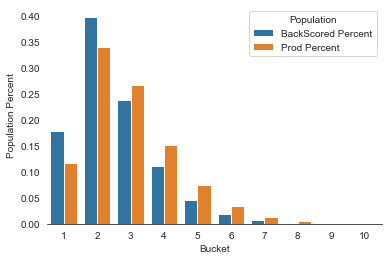

In [15]:
p = sns.barplot(x="Bucket", y="Percent", hue="Population", data=percents)
p.set(xlabel='Bucket', ylabel='Population Percent')
sns.despine(left=True)

In [16]:
df['PSI'] = (df['Prod Percent'] - df['BackScored Percent']) * np.log(df['Prod Percent'] / df['BackScored Percent'])

In [17]:
df

,Bucket,Breakpoint Value,BackScored Count,Prod Count,BackScored Percent,Prod Percent,PSI
0,1,0.063546,5683,28971,0.178497,0.115843,0.027088
1,2,0.110451,12659,84697,0.397607,0.338669,0.009456
2,3,0.157355,7556,66584,0.237326,0.266242,0.003324
3,4,0.204260,3543,37869,0.111282,0.151423,0.012364
4,5,0.251164,1468,18656,0.046108,0.074598,0.013707
5,6,0.298069,609,8368,0.019128,0.033460,0.008015
6,7,0.344973,225,3240,0.007067,0.012955,0.003569
7,8,0.391878,68,1182,0.002136,0.004726,0.002058
8,9,0.438783,17,392,0.000534,0.001567,0.001113
9,10,0.485687,10,93,0.000314,0.000372,0.000010


In [18]:
np.sum(df['PSI'])

0.08070207114514018